## Import package

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration & Intuition

In [22]:
df_train=pd.read_csv("./original_data/mitbih_train.csv")
df_test=pd.read_csv("./original_data/mitbih_test.csv")

In [23]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [24]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

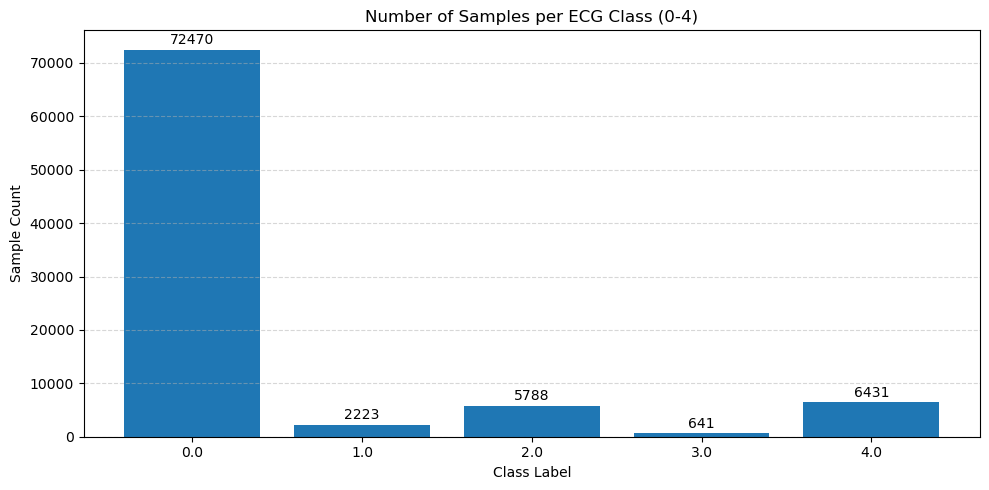

In [25]:
class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.index.astype(str), class_counts.values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 500,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title("Number of Samples per ECG Class (0-4)")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


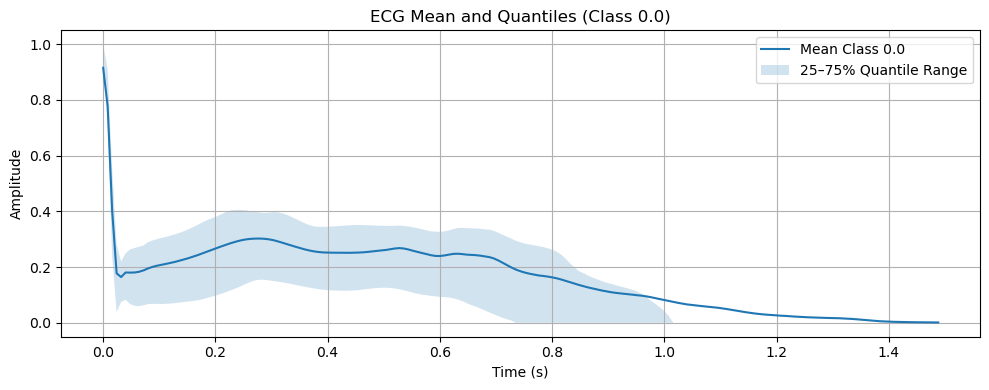

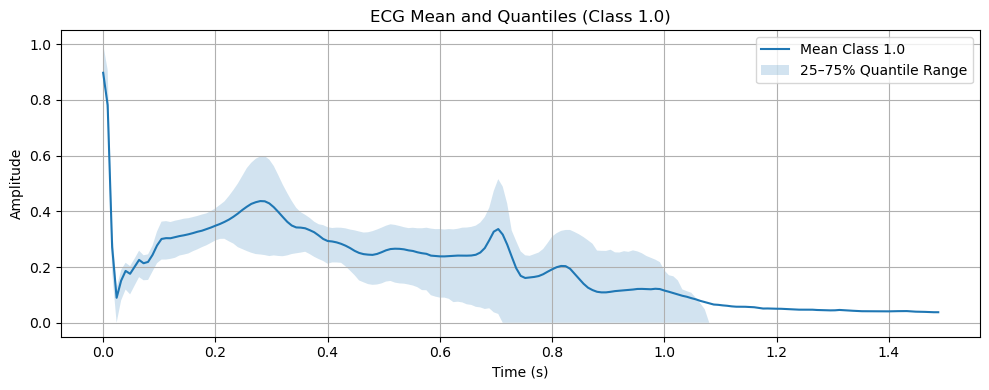

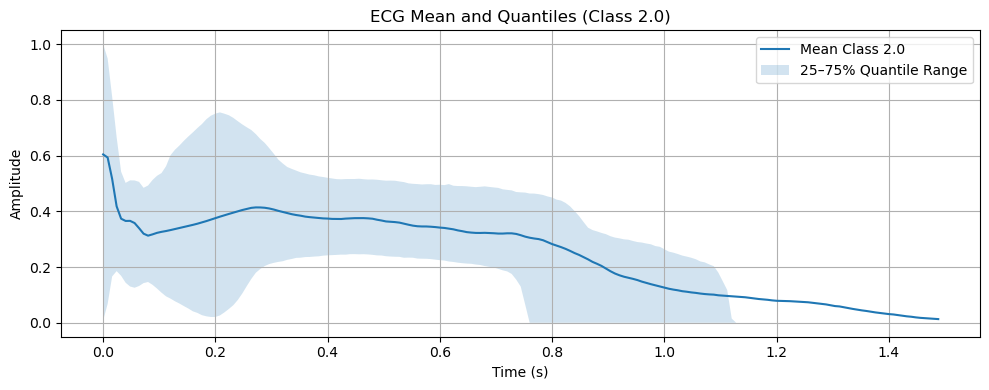

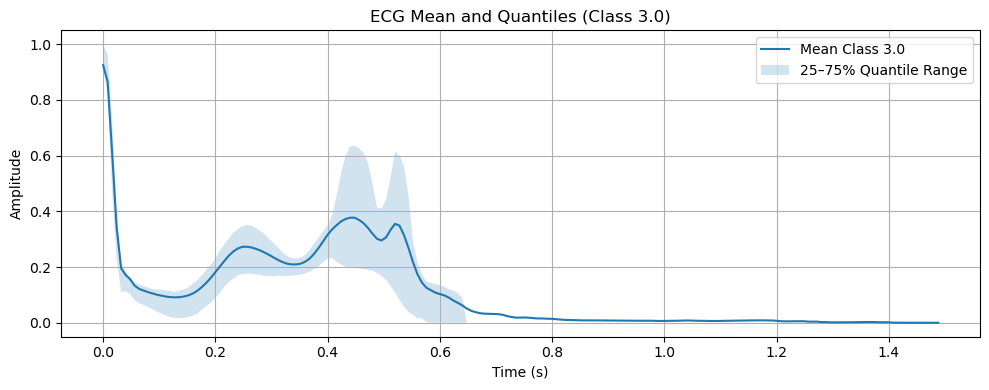

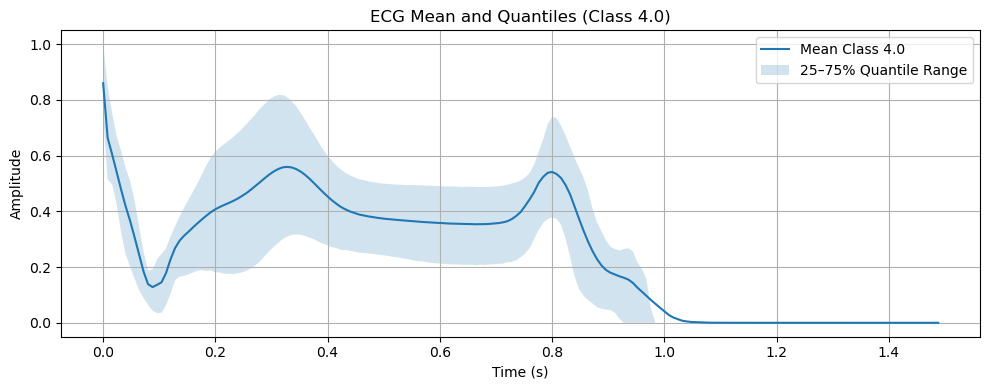

In [26]:
classes = sorted(y_train.unique())

lower_q = 0.25
upper_q = 0.75

for label in classes:
    class_samples = X_train_[y_train == label]
    
    mean_waveform = class_samples.mean(axis=0)
    lower_quantile = class_samples.quantile(lower_q, axis=0)
    upper_quantile = class_samples.quantile(upper_q, axis=0)
    
    t = np.arange(class_samples.shape[1]) / 125

    plt.figure(figsize=(10, 4))
    plt.plot(t, mean_waveform, label=f"Mean Class {label}")
    plt.fill_between(t, lower_quantile, upper_quantile, alpha=0.2,
                     label=f"{int(lower_q*100)}–{int(upper_q*100)}% Quantile Range")
    
    plt.title(f"ECG Mean and Quantiles (Class {label})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Resampling

In [30]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 20000}) 
over_sampler = SMOTETomek(sampling_strategy={1: 10000, 
                                        2: 10000, 
                                        3: 3000, 
                                        4: 10000})

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)


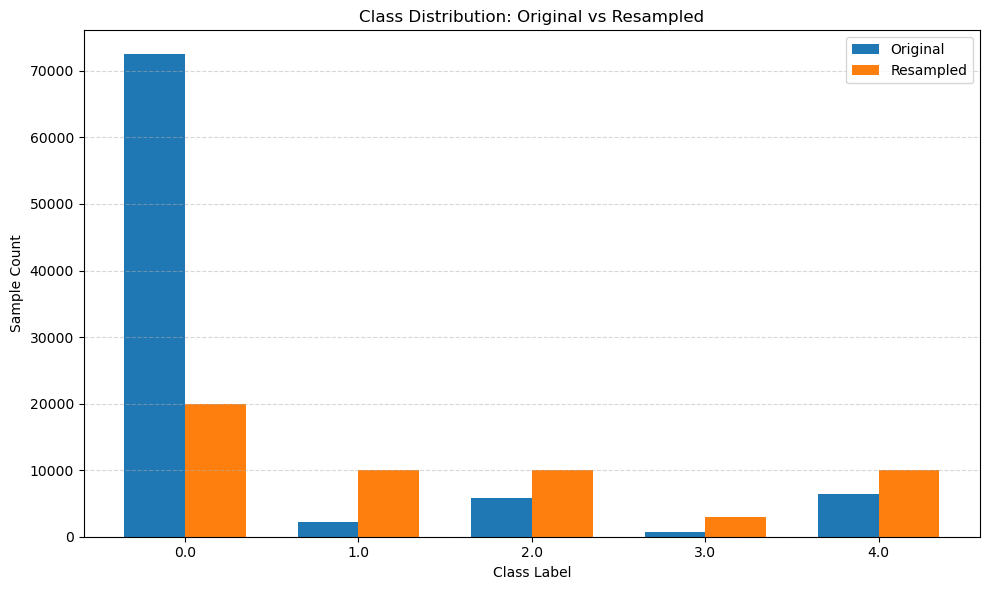

In [31]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## XGBOOST

In [60]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, make_scorer

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

In [62]:
X_train.columns==X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [63]:
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)
valid = xgb.DMatrix(data=X_valid, label=y_valid)

In [64]:
def custom_weighted_recall(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)  
    
    weights = [0.1,1,1,1,1]
    recall = recall_score(labels, preds, average='weighted', sample_weight=weights)
    return 'custom_weighted_recall', recall

In [65]:
params = {
    'objective': 'multi:softmax',  
    'num_class': 5,                
    'eval_metric': 'mlogloss',     
    'max_depth': 6,                
    'eta': 0.1,                    
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'random_state': 42             
}


evals = [(train, 'train'), (valid, 'eval')]


xgbmodel = xgb.train(
    params=params, 
    dtrain=train, 
    num_boost_round=1000, 
    evals=evals,           
    early_stopping_rounds=50
)

[0]	train-mlogloss:1.44058	eval-mlogloss:1.44396
[1]	train-mlogloss:1.29802	eval-mlogloss:1.30434
[2]	train-mlogloss:1.18376	eval-mlogloss:1.19235
[3]	train-mlogloss:1.08329	eval-mlogloss:1.09371
[4]	train-mlogloss:0.99752	eval-mlogloss:1.00957
[5]	train-mlogloss:0.92397	eval-mlogloss:0.93726
[6]	train-mlogloss:0.85841	eval-mlogloss:0.87281
[7]	train-mlogloss:0.79945	eval-mlogloss:0.81552
[8]	train-mlogloss:0.74779	eval-mlogloss:0.76528
[9]	train-mlogloss:0.70208	eval-mlogloss:0.72071
[10]	train-mlogloss:0.66102	eval-mlogloss:0.68062
[11]	train-mlogloss:0.62306	eval-mlogloss:0.64384
[12]	train-mlogloss:0.58946	eval-mlogloss:0.61110
[13]	train-mlogloss:0.55796	eval-mlogloss:0.58041
[14]	train-mlogloss:0.52845	eval-mlogloss:0.55183
[15]	train-mlogloss:0.50198	eval-mlogloss:0.52615
[16]	train-mlogloss:0.47679	eval-mlogloss:0.50179
[17]	train-mlogloss:0.45463	eval-mlogloss:0.48029
[18]	train-mlogloss:0.43300	eval-mlogloss:0.45951
[19]	train-mlogloss:0.41451	eval-mlogloss:0.44162
[20]	train

In [66]:
xgbmodel.best_score

0.05542623706873875

In [67]:
xgbmodel.best_iteration

965

In [68]:
y_pred = xgbmodel.predict(test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9899    0.9861    0.9880     18117
         1.0     0.7368    0.8058    0.7698       556
         2.0     0.9395    0.9537    0.9465      1448
         3.0     0.8261    0.8210    0.8235       162
         4.0     0.9813    0.9795    0.9804      1608

    accuracy                         0.9777     21891
   macro avg     0.8947    0.9092    0.9016     21891
weighted avg     0.9783    0.9777    0.9779     21891



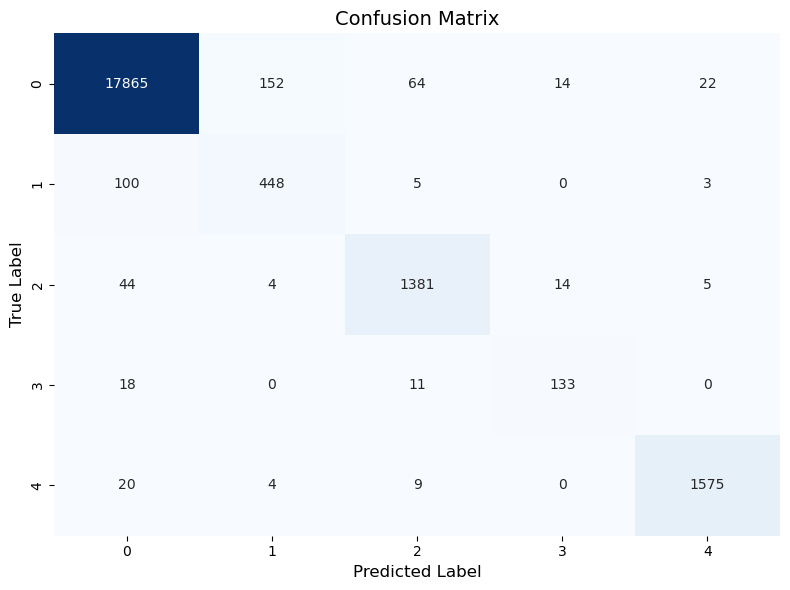

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Hyperparameter Optimization

In [70]:
def custom_weighted_recall(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
    weights = np.array([0.1, 1, 1, 1, 1])
    return np.sum(recalls * weights) / np.sum(weights)
    
weighted_recall_scorer = make_scorer(custom_weighted_recall, greater_is_better=True)

In [71]:
param_grid = {
    'max_depth': [4, 6, 8],
    'eta': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    random_state=13
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=weighted_recall_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1
)

In [72]:
grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 